## CV и классификация изображений

**Выполнил Мелехин Николай Сергеевич**


In [26]:
# !pip install -q torchinfo

In [27]:
import time
import warnings
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary  # не забудьте выполнить pip install torchinfo

from IPython.display import clear_output

sns.set(font_scale=1, style="darkgrid", palette="Set2")
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## 1. Классификация изображений

В этом ноутбуке мы будем работать с `torch`. Будем решать задачу классификации и сравним два подхода: полносвязная сеть (fully-connected NN или MLP) и сверточная сеть (CNN). 

###  1.1. Датасет FashionMNIST

Датасет состоит из 70 000 картинок размера 28х28х1 из 10 разных классов.

60 000 &mdash; обучающая выборка, 10 000 &mdash; тестовая. Пример картинок из датасета:

![alt text](image.png)

Загрузим его из коллекции датасетов библиотеки `torchvision` в RAM.

In [28]:
# Данные для обучения
train_dataset = torchvision.datasets.FashionMNIST(
    root="./fashion", download=True, train=True, transform=transforms.ToTensor()
)

# Данные для тестирования
val_dataset = torchvision.datasets.FashionMNIST(
    root="./fashion", download=True, train=False, transform=transforms.ToTensor()
)

# Классы объектов в датасете
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)

Отметим, что датасеты из torchvision являются instance типа `torch.utils.data.Dataset`. Это позволяет использовать их с удобными инструментами из `torch.utils.data`.

In [29]:
isinstance(train_dataset, torch.utils.data.Dataset)

True

Проверим размеры датасетов.

In [30]:
len(train_dataset), len(val_dataset)

(60000, 10000)

Визуализируем по картинке из train и val датасета.

Размер картинки:torch.Size([1, 28, 28])


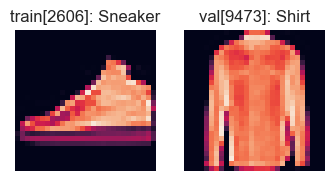

In [31]:
# берем 2 рандомных индекса
train_idx, val_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[train_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f"val[{val_idx}]: {classes[val_dataset[val_idx][1]]}")
plt.axis("off");

**Data Loader / Генератор батчей**

Заметим, что в этот раз данных очень много, и прогонять весь датасет через модель за раз &mdash; плохая идея. Гораздо лучше тренировать модель постепенно, небольшими кусочками датасета (батчами). Нам нужен *генератор батчей*.

Для этого на pytorch есть универсальный класс [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) &mdash; гибкий генератор батчей. Он поддерживает разные типы датасетов, перемешивание данных при семплировании, многопроцессорность.

**Важные аргументы:**

*   `dataset` &mdash; объект типа [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) или [`torch.utils.data.IterableDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset), из которого будем семплировать.
*   `batch_size` (int) &mdash; размер батча
*   `shuffle` (bool) &mdash; перемешивать ли данные
*   `num_workers` (int) &mdash; количество параллельных процессов. Ускоряет работу, даст предупреждение, если указать больше workers, чем допустимо на вашей системе. Установите значение -1, чтобы использовать максимально возможное количество.

**Использование:**
```
for X_batch, y_batch in dataloader:
    <...>
```
Здесь `X_batch`, `y_batch` &mdash; объекты размера `batch_size`. Цикл проходит по всему датасету в определенном порядке, пока не закончится объекты в датасете. То есть каждый объект будет возвращен ровно 1 раз.

> Обучающую выборку принято передавать в перемешанном (`shuffle=True`) виде, это увеличивает обобщающую способность модели и уменьшает переобучение.

> Тестовую выборку не перемешивают! Ведь обучение модели уже завершено, и порядок данных не влияет на результат.


In [32]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

### 1.2. Функции для обучения модели

Стандартный цикл обучения на Pytorch:

```
for i in range(num_epochs):
    y_pred = model(x)               # forward pass
    loss = loss_function(y_pred, y) # вычисление функции потерь (Loss)
    loss.backward()                 # backward pass
    optimizer.step()                # шаг оптимизации
    optimizer.zero_grad()           # обнуляем градиенты
```

В этот раз мы будем обучать несколько моделей, а также визуализировать историю. Для этого удобно обернуть все в функцию `train`. Она записывает лосс и метрики в `history`, измеряет время каждой эпохи, на каждой эпохе проводит два этапа:
1. Обучение модели &mdash; полный проход по `train` датасету, подсчет лосса и точности на каждой итерации.  
2. Валидация модели &mdash; полный проход по `val` датасету, подсчет лосса и точности на каждой итерации.

> Бывают слои, поведение которых отличается при обучении и тестировании. Переключать режим модели можно с помощью `model.train(True)` и `model.train(False)` (эквивалентно `model.eval()`).

> Для ускорения работы и избежания ошибок в валидации принято использовать `with torch.no_grad():`. Эта обертка говорит Pytorch, что сейчас градиенты считать не надо.

In [33]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=30
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

In [34]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

### 1.3. Multi-Layer Perceptron Baseline

Начнем с простой нейросети-MLP из линейных слоев и функций активации:

In [35]:
simple_mlp = nn.Sequential(
    # расплющиваем картинку (C, H, W) в вектор (C * H * W, )
    nn.Flatten(),
    nn.Linear(in_features=1 * 28 * 28, out_features=192),
    # без функции активации модель будет линейной и глупой :(
    nn.ReLU(),
    nn.Linear(in_features=192, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.Linear(
        in_features=32, out_features=10
    ),  # логиты (logits) для 10 классов
).to(device)

Можно посмотреть количество параметров модели и размерность на промежуточных этапах с помощью `torchinfo.summary(model, input_size)`. Также это удобный способ проверить, что все размерности сходятся, иначе будет ошибка.

In [36]:
summary(simple_mlp, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 192]                  150,720
├─ReLU: 1-3                              [1, 192]                  --
├─Linear: 1-4                            [1, 64]                   12,352
├─ReLU: 1-5                              [1, 64]                   --
├─Linear: 1-6                            [1, 32]                   2,080
├─ReLU: 1-7                              [1, 32]                   --
├─Linear: 1-8                            [1, 10]                   330
Total params: 165,482
Trainable params: 165,482
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.66
Estimated Total Size (MB): 0.67

Применим ее к нашим данным $-$ картинкам из датасета:

In [37]:
# Кросс-энтропия - общепринятый лосс для классификации
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.ASGD(simple_mlp.parameters(), lr=0.05)

history_mlp = train(
    simple_mlp, criterion, optimizer, train_batch_gen, val_batch_gen
)
# Сохраняем веса модели в файл
torch.save(simple_mlp.state_dict(), "simple_mlp.pth")

Epoch 30 of 30 took 9.805 s
  training loss: 	0.191537
  validation loss: 	0.347854
  training accuracy: 			92.90 %
  validation accuracy: 			88.53 %


Визуализируем потери и точность:

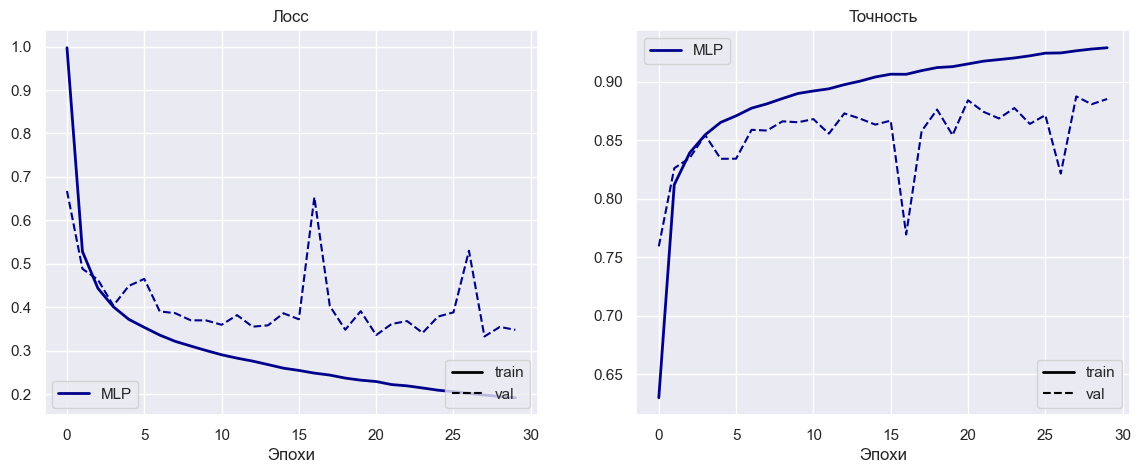

In [38]:
plot_histories([history_mlp], ["MLP"])

Как видим, модель MLP правильно предсказывает класс из возможных 10 примерно в 90% случаев.

<a name="cnn"></a>
### 1.4. Свёрточная нейросеть

**Свёрточная нейросеть (CNN)** &mdash; это многослойная нейросеть, имеющая в своей архитектуре свёрточные и pooling-слои.

Простые свёрточные нейросети для классификации почти всегда строятся по следующему правилу:

$INPUT \to [[CONV -> RELU]^N \to POOL?]^M \to [FC -> RELU]^K \to FC$, где "?" обозначает опциональные слои.


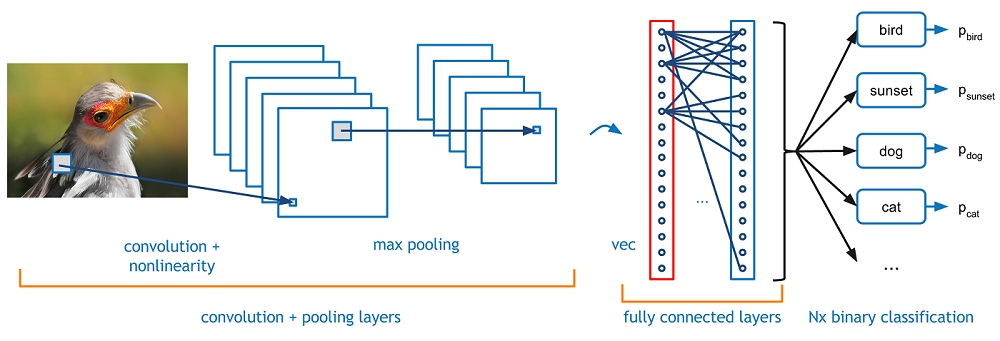

Поясним схему:
1. Вход &mdash; это batch картинок размера CxHxW.

2. **Feature extractor** &mdash; последовательность сверток и pooling-слоев(convolution + pooling layers). Он распознает сложные паттерны и преобразует картинку в некоторый вектор, содержащий в себе всю информацию о найденных паттернах. Таким образом, мы значительно уменьшаем размерность картинки, оставляя только то, что нам интересно для классификации.

> Лучше использовать несколько сверток с маленьким ядром, чем одну свертку с большим ядром, так как глубина увеличивает сложность паттернов, которые может распознать CNN.

> Pooling &mdash; основной инструмент снижения размерности. Как следствие, он понижает вычислительную сложность, а также помогает бороться с переобучением.

3. **Classifier** &mdash; принимает вектор-представление картинки после feature extractor-а и выдает 10 логитов, соответствующих каждому классу. Логиты - это вещественные числа. К ним можно применить `torch.softmax()`, чтобы получить вероятность.

Создадим сверточную нейронную сеть. Нам понадобятся новые слои:

[`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

* `in_channels` (int) &mdash; количество каналов во входном изображении

* `out_channels` (int) &mdash; количество каналов после применения свертки (кол-во фильтров, которые будут применены)

* `kernel_size` (int, tuple) &mdash; размер сверточного ядра

* `stride` (int, tuple) &mdash; шаг, с которым будет применена свертка.

* `padding` (int, tuple) &mdash; добавление по краям изображения дополнительных пикселей.


[`nn.MaxPool2d(kernel_size, stride=None)`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

* `kernel_size` (int, tuple) &mdash; размер окна, из которого брать максимум

* `stride` (int, tuple) &mdash; шаг, с которым двигаем окно.

In [91]:
simple_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=192),
    nn.ReLU(),
    nn.Linear(in_features=192, out_features=10),
).to(device)

Подберём архитектуру CNN так, чтобы количество параметров было примерно таким же, как было в MLP. Иначе сравнение было бы нечестным: сеть с бóльшим количеством параметров имела бы преимущество.

In [92]:
summary(simple_cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 26, 26]           280
├─MaxPool2d: 1-2                         [1, 28, 13, 13]           --
├─ReLU: 1-3                              [1, 28, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 13, 13]           1,856
├─MaxPool2d: 1-5                         [1, 64, 6, 6]             --
├─ReLU: 1-6                              [1, 64, 6, 6]             --
├─Flatten: 1-7                           [1, 2304]                 --
├─Linear: 1-8                            [1, 192]                  442,560
├─ReLU: 1-9                              [1, 192]                  --
├─Linear: 1-10                           [1, 10]                   1,930
Total params: 446,626
Trainable params: 446,626
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.95
Input size (MB): 0.00
Forward/b

Обучим CNN:

In [93]:
# Кросс-энтропия - общепринятый лосс для классификации
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.ASGD(simple_cnn.parameters(), lr=0.05)

history_cnn = train(
    simple_cnn,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=30,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn.state_dict(), "simple_cnn.pth")

Epoch 30 of 30 took 21.727 s
  training loss: 	0.159802
  validation loss: 	0.279821
  training accuracy: 			94.12 %
  validation accuracy: 			90.60 %


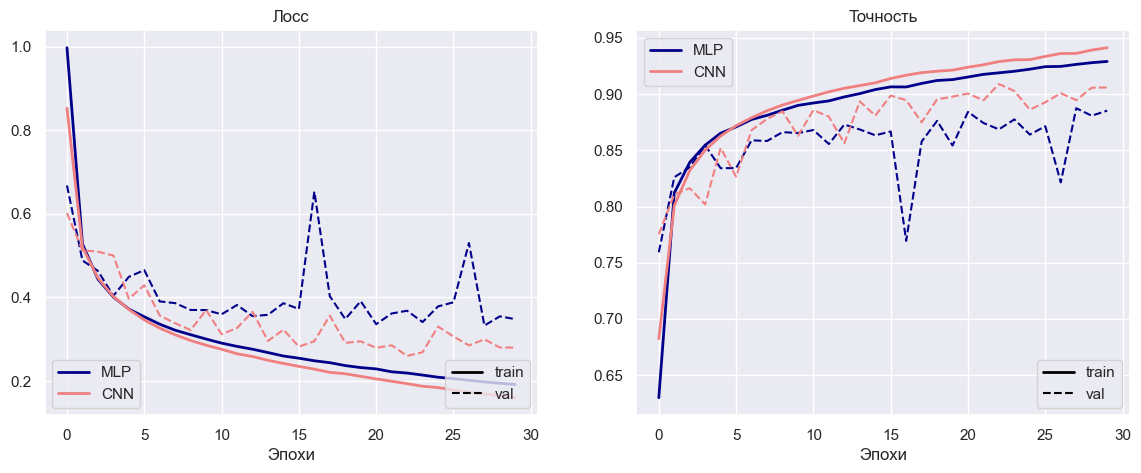

In [94]:
plot_histories([history_mlp, history_cnn], ["MLP", "CNN"])

Мы смогли достичь лучшего качества с CNN на 2%, чем MLP.

### 1.5. Визуализация предсказаний

In [95]:
# Если нужно загрузить модели из файла на CPU
simple_mlp.load_state_dict(
    torch.load("simple_mlp.pth", map_location=torch.device(device))
)
simple_cnn.load_state_dict(
    torch.load("simple_cnn.pth", map_location=torch.device(device))
)
simple_mlp.eval()
simple_cnn.eval();

Наконец, посмотрим на сами предсказания!

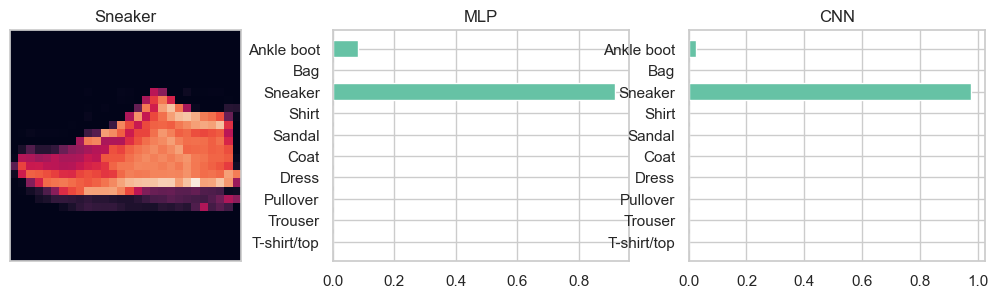

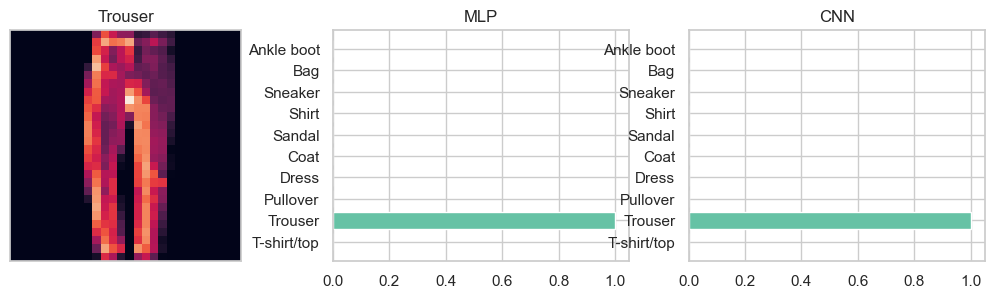

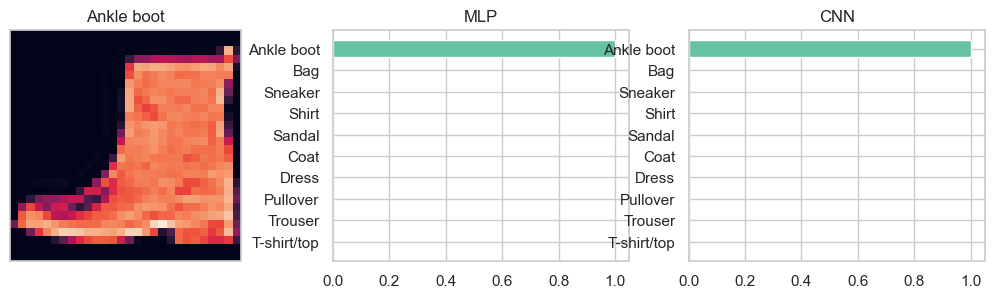

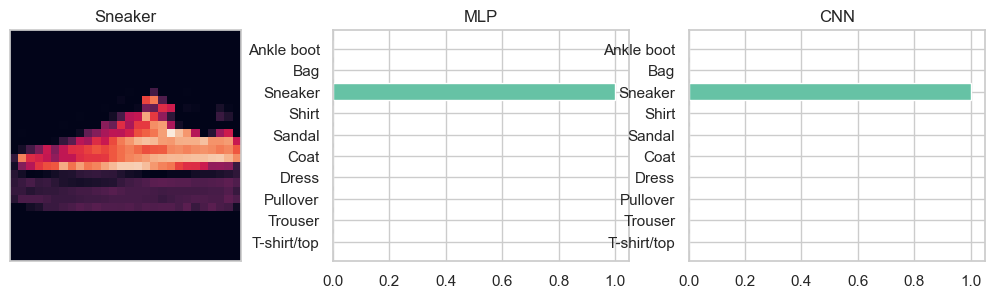

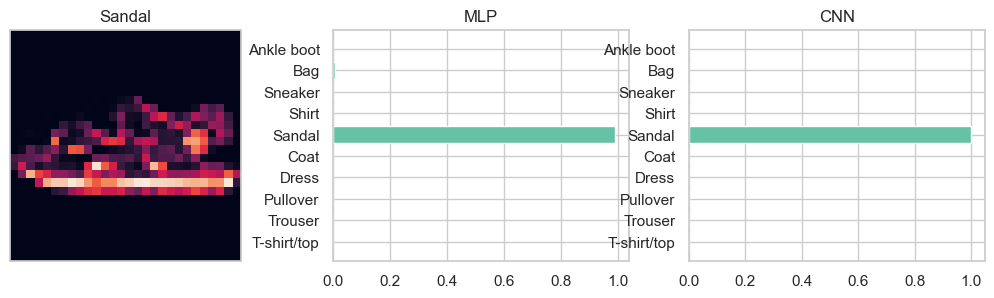

In [96]:
for i in np.random.randint(0, len(val_dataset), 5):
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(13, 3))

        # Достаем 1 рандомный объект из тестового датасета
        image, label = val_dataset[i]

        plt.subplot(1, 3, 1)
        plt.imshow(image.permute((1, 2, 0)))
        plt.title(classes[label])
        plt.xticks([])
        plt.yticks([])

        # Не забываем выключить градиенты на момент вычислений
        with torch.no_grad():
            logits_mlp = simple_mlp(image.to(device).unsqueeze(0))[0].cpu()
            logits_cnn = simple_cnn(image.to(device).unsqueeze(0))[0].cpu()

        # Чтобы логиты перевести в вероятности применяем softmax по оси классов
        prob_mlp = torch.softmax(logits_mlp, dim=0)
        prob_cnn = torch.softmax(logits_cnn, dim=0)

        plt.subplot(1, 3, 2)
        plt.barh(classes, prob_mlp)
        plt.title("MLP")

        plt.subplot(1, 3, 3)
        plt.barh(classes, prob_cnn)
        plt.title("CNN")

**Вывод:** Обе модели дают хорошие результаты, более 90%. CNN немного лучше чем MLP.